# Proyecto 03: Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

En este proyecto, vamos a trabajar con los datos de los años 2017, 2018 y 2019. Se tomarán en cuenta únicamente los datos para la **Autopista Illia** con **pago en efectivo**.


### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?


## 1. Preparación del Dataset

El primer paso será importar las librerías que vamos a utilizar durante el desarrollo del proyecto:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import sklearn.metrics as metrics
import matplotlib.gridspec as gs
import statsmodels.tsa as tsa
import statsmodels.api as sm
import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

A continuación, importaremos los datasets correspondientes a los años 2017, 2018 y 2019.

In [2]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

Realizo un chequeo general de cada dataset y visualizo sus primeras cinco instancias:

- **Año 2019:**

In [3]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


- **Año 2018:**

In [4]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


- **Año 2017:**

In [5]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos los valores que toman los campos **estacion, sentido, tipo_vehiculo** y **forma_pago**

In [6]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [7]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [8]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [9]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año - día - mes

**hora_inicio** hora de inicio de la cuenta de vehículos (DROP)

**hora_fin** hora de fin de la cuenta de vehículos (Vamos a usar esta para tomar la hora)

**dia**: día de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019. Antes se dividía en Dellepiane Liniers y Centro. Se agrega PDB).

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehículos

Vamos a trabajar únicamente con la estación **Illia** y la forma de pago **Efectivo**:

In [10]:
# Unimos los 3 datasets, lo hacemos directamente, ya que tienen la misma cantidad de columnas:
dataset = pd.concat([data_2019, data_2018, data_2017])

# Creamos una máscara para tomar únicamente con los datos de la estación Illia y la forma de pago Efectivo:
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

# Descartamos las columnas que no vamos a utilizar:
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [11]:
# Pasamos la columna fecha a formato datetime y le añadimos hora_fin como hora:
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

# Dscartamos las columnas fecha y hora_fin, ya que fueron previamente incluidas en el campo fecha2:
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [12]:
# Renombramos la columna fecha2 como fecha:
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [13]:
# Reordenamos el dataset por fecha:
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)

dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


A continuación graficamos los datos resultantes, después de realizar las modificaciones previas:

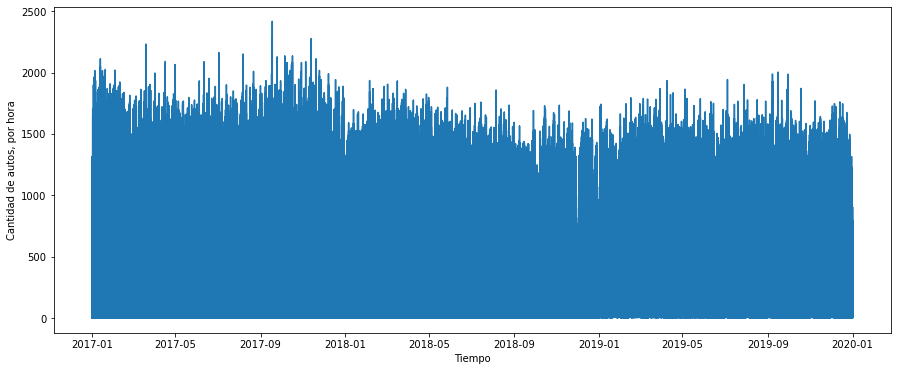

In [14]:
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

Con el fin de mejorar la visualización, resampleamos los datos para agruparlos por día:

In [15]:
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


Graficamos nuevamente con los datos agrupados diariamente:

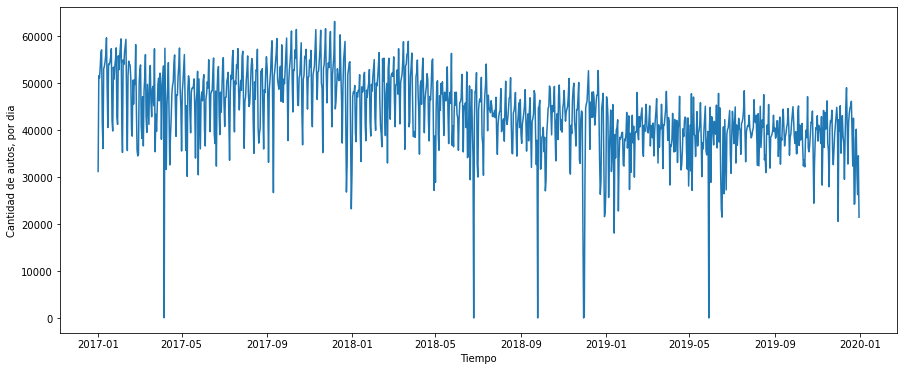

In [16]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

# Análisis Exploratorio de Datos


Exploración de los años 2017 - 2018 - 2019 para forma de pago EFECTIVO **por separado**:

- **Año 2017:**

In [17]:
data_2017.info()

data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


- **Año 2018:**

In [18]:
data_2018.info()

data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


- **Año 2019:**

In [19]:
data_2019.info()

data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


Descarto las columnas que no voy a utilizar para mejorar el estudio de los datasets:

In [20]:
data_2019.drop(columns=["hora_inicio", "hora_fin"], inplace=True)
data_2018.drop(columns=["hora_inicio", "hora_fin"], inplace=True)
data_2017.drop(columns=["hora_inicio", "hora_fin"], inplace=True)

Imprimo la cantidad de vehículos registrados para cada año:

In [21]:
print("Cantidad de autos registrados año 2017: ", data_2017[data_2017["estacion"] == "Illia"].cantidad_pasos.count())
print("Cantidad de autos registrados año 2018: ", data_2018[data_2018["estacion"] == "Illia"].cantidad_pasos.count())
print("Cantidad de autos registrados año 2019: ", data_2019[data_2019["estacion"] == "Illia"].cantidad_pasos.count())

Cantidad de autos registrados año 2017:  291900
Cantidad de autos registrados año 2018:  299519
Cantidad de autos registrados año 2019:  161133


Imprimo la cantidad de vehículos registrados con método de pago *Efectivo* para cada año:

In [22]:
print("Cantidad de autos registrados año 2017 y forma_pago EFECTIVO: ", data_2017[(data_2017["estacion"] == "Illia") & (data_2017["forma_pago"] == "EFECTIVO")].cantidad_pasos.count())
print("Cantidad de autos registrados año 2018 y forma_pago EFECTIVO: ", data_2018[(data_2018["estacion"] == "Illia") & (data_2018["forma_pago"] == "EFECTIVO")].cantidad_pasos.count())
print("Cantidad de autos registrados año 2019 y forma_pago EFECTIVO: ", data_2019[(data_2019["estacion"] == "Illia") & (data_2019["forma_pago"] == "EFECTIVO")].cantidad_pasos.count())

Cantidad de autos registrados año 2017 y forma_pago EFECTIVO:  104230
Cantidad de autos registrados año 2018 y forma_pago EFECTIVO:  99996
Cantidad de autos registrados año 2019 y forma_pago EFECTIVO:  34643


* Se observa cómo el flujo de vehículos a través de los años desciende considerablemente para todas las formas de pago. En efectivo, específicamente en los últimos dos años observados la reducción es del 60% de un año a otro.
        
- Se puede inferir que esto se debe a que se migró a otras formas de pago a través de los años.
- Otra posibilidad es que las personas empezaran a usar otras rutas más convenientes
        
* Para demostrar esto vamos a estudiar las formas de pago a través de los años, observando si alguna muestra una tendencia ascendente o descendente en estos tres años. Por último, para complementar la investigación, se buscará información externa al dataset para observar si en esos años se construyó algún nuevo acceso que los vehículos hayan podido utilizar en lugar de la Autopista Illia.


## Preguntas a responder:

* ¿Cuál es el día, en los 3 años observados, más concurrido?
* ¿Cuál es el horario, en los 3 años observados, más concurrido?
* ¿Cual es el sentido, en los 3 años observados, que más cantidad de autos contó?



Para contestar estas preguntas y realizar un análisis exploratorio profundo de los datos obtenidos, se estudiará el dataset en conjunto *(los 3 años observados)* y también por separado. De esta forma, se obtendrán los indicadores para entender los datos y generar mejores predicciones.

## Respondiendo preguntas:

In [23]:
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01
1,Domingo,Provincia,Liviano,9,2017-01-01
2,Domingo,Provincia,Liviano,644,2017-01-01
3,Domingo,Provincia,Pesado,6,2017-01-01
4,Domingo,Provincia,Pesado,1,2017-01-01


Se utilizará el dataset con los 3 años concatenados para responder las preguntas formuladas anteriormente, para esto se utilizarán las funciones *group_by* y *sort_values* como se muestra a continuación:

In [24]:
dataset.groupby("dia").sum().sort_values("cantidad_pasos", ascending=False)

,cantidad_pasos
dia,
Viernes,7647272
Jueves,7302169
Miércoles,7125526
Martes,6865551
Lunes,6691387
Sábado,6441715
Domingo,5791961


In [25]:
dataset.groupby("fecha").sum().sort_values("cantidad_pasos", ascending=False)

,cantidad_pasos
fecha,
2017-10-05 18:00:00,4412
2017-11-17 14:00:00,4375
2017-12-07 16:00:00,4369
2017-10-13 15:00:00,4331
2017-11-24 15:00:00,4206
...,...
2019-02-11 21:00:00,3
2017-12-24 00:00:00,3
2017-01-01 01:00:00,1


In [26]:
dataset.groupby("sentido").sum().sort_values("cantidad_pasos", ascending=False)

,cantidad_pasos
sentido,
Centro,24707366
Provincia,23158215


**Respuestas:**

1) El día de mayor ocupación vehicular es el **Viernes**, con un total de 7.647.272 pasos. 

2) La mayor ocupación vehicular se presenta a las **18:00** y a las **14:00** (con valores de 4.412 y 4.375 respectivamente). Se infiere que este comportamiento se debe a que en estas horas específicas del día los trabajadores de *Buenos Aires* se desplazan desde la *Capital* a sus hogares. Cabe resaltar que la autopista *Illia* es muy utilizada como acceso a la *Capital*.

3) El sentido más concurrido es el sentido **Centro** con un total de 24.707.366 pasos.

## Valores Faltantes

A continuación, se genera una suma de los valores faltantes en el dataset para la frecuencia *diaria*:

In [27]:
diario.isna().sum()

cantidad_pasos    0
dtype: int64

In [28]:
diario.index.to_series().diff().value_counts()

1 days    1094
Name: fecha, dtype: int64

In [29]:
diario

,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486
...,...
2019-12-27,40182
2019-12-28,30681
2019-12-29,26259


La serie no presenta valores faltantes. 

Al estudiar la serie resampleada en su frecuencia diaria, nos encontramos con que posee **1095 días observados** y la función aplicada indica **1094** instancias con 1 día de diferencia en cada una. 

Esto indica que la serie se encuentra **sin** valores faltantes y cumple los requisitos para ser modelada.

## Valores Atípicos

Como se evidencia en los gráficos, la serie a través de los años presenta ciertos registros muy por debajo del promedio. Estos son considerados *Valores Atípicos*. Se estudiarán las razones por las cuales se generan estos valores.

In [30]:
diario.describe()

,cantidad_pasos
count,1095.000000
mean,43712.859361
std,8192.736927
min,0.000000
25%,39061.500000
50%,43761.000000
75%,49498.000000
max,63127.000000


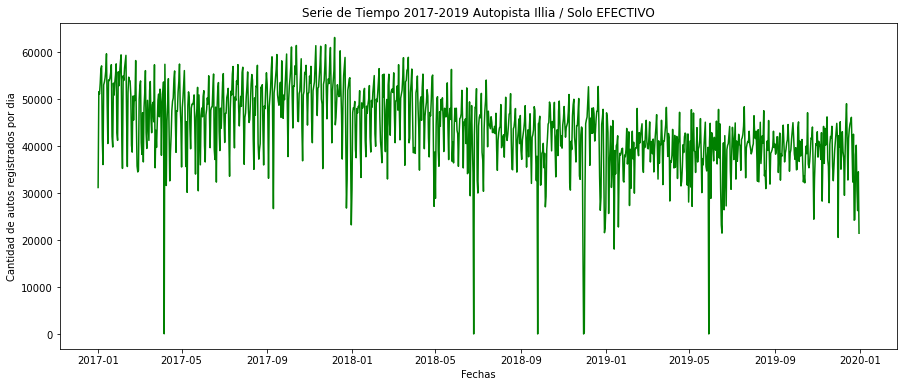

In [31]:
plt.figure(figsize=(15,6))

plt.plot(diario.index, diario.cantidad_pasos, color= "g")
plt.title("Serie de Tiempo 2017-2019 Autopista Illia / Solo EFECTIVO")
plt.xlabel("Fechas")
plt.ylabel("Cantidad de autos registrados por dia")
plt.show()

Como se observa, la serie presenta un promedio por encima de los **43000**.

A continuación, se instanciarán los **Valores Atípicos** que presenta la serie y se van a generar gráficos para facilitar su visualización. En caso de no encontrar la justificación a estas discrepancias dentro del dataset, se realizará un búsqueda en Internet para verificar si en la Ciudad de *Buenos Aires, Argentina* hubo algún evento en las fechas estudiadas, que pueda explicar este comportamiento. 

Se crearán máscaras para luego generar los gráficos correspondientes:

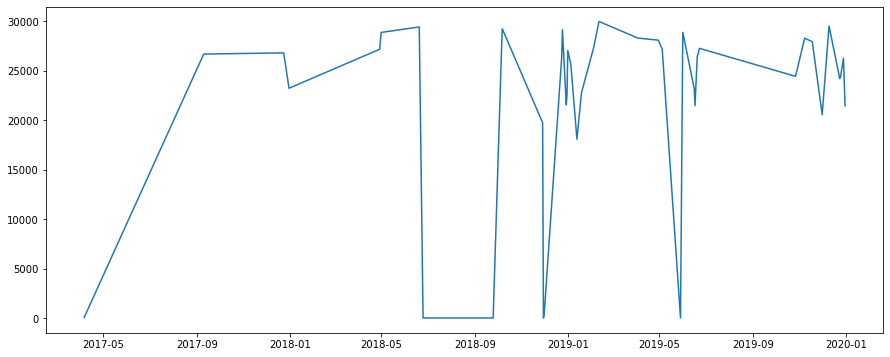

In [32]:
mascara1 = diario[diario.cantidad_pasos <= 30000]

plt.figure(figsize=(15,6))
plt.plot(mascara1)

In [33]:
mascara1

,cantidad_pasos
fecha,
2017-04-06,40
2017-09-10,26684
2017-12-24,26805
2017-12-31,23229
2018-04-29,27169
2018-05-01,28870
2018-06-20,29428
2018-06-25,0
2018-09-25,0


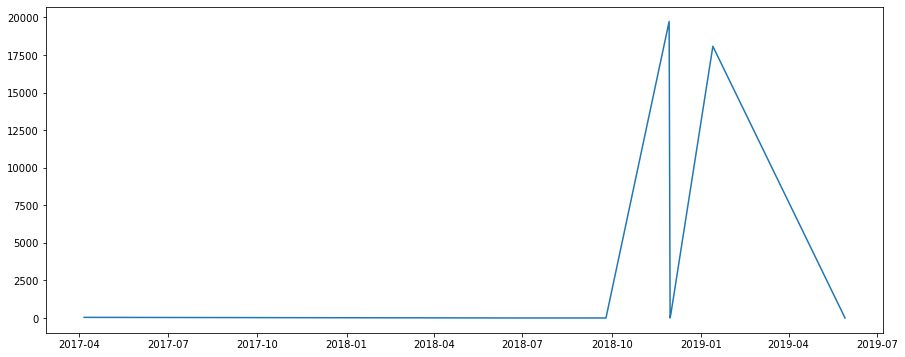

In [34]:
mascara2 =  diario[diario.cantidad_pasos <= 20000]

plt.figure(figsize=(15,6))
plt.plot(mascara2)

In [35]:
mascara2

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-29,19728
2018-11-30,0
2018-12-01,350
2019-01-13,18076
2019-05-29,0


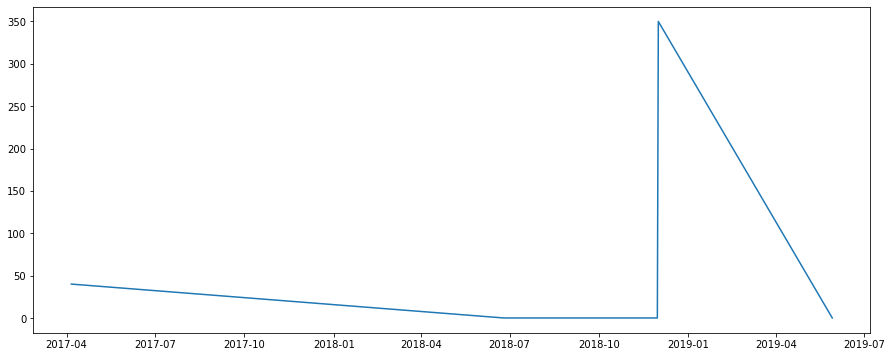

In [36]:
mascara3 = diario[diario.cantidad_pasos <= 10000]

plt.figure(figsize=(15,6))
plt.plot(mascara3)

In [37]:
mascara3

,cantidad_pasos
fecha,
2017-04-06,40
2018-06-25,0
2018-09-25,0
2018-11-30,0
2018-12-01,350
2019-05-29,0


Luego de instanciar los valores en distintas máscaras con distintos parámetros, se genera información más clara en relación a los días, sin embargo, aún se desconocen los motivos por los cuales se presentan estos registros.

La **mascara1** demuestra que al instanciar la *cantidad_pasos* por debajo de *30000* se devuelven muchas instancias. Luego, luego en la **mascara2** se observa que instanciando por debajo de los *20000 cantidad_pasos*, los registros se vuelven mucho más concisos y se registran grandes diferencias en cuanto a la primera máscara.

Cuando se instanció la *cantidad_pasos* por debajo de *10000* las fechas registradas fueron **2** menos que en **mascara2**. Por esta razón, **mascara2** es la que se utilizará para justificar estos **valores atípicos**.


Se realizará una búsqueda de las fechas obtenidas en la **mascara2** en Internet, para intentar justificar estos valores:


**FECHAS QUE REGISTRARON VALORES ATIPICOS:**

- **2017-04-06:**  40

- **2018-06-25:**  0

- **2018-09-25:**  0

- **2018-11-29:**  19728

- **2018-11-30:**  0

- **2018-12-01:**  350

- **2019-01-13:**  18076

- **2019-05-29:**  0

## Buscando información por fuera del dataset 
### Identificando fechas:

En esta sección voy a buscar información por fuera del dataset para tratar entender por qué se presentaron estos *Valores Atípicos*. A continuación, se relacionan las fechas en cuestión:


- **2017-04-06**: Al parecer el *06 de Abril del año 2017* hubo un paro nacional

Link a la noticia: https://elpais.com/internacional/2017/04/06/argentina/1491441490_387006.html


- **2018-06-25**: El *25 de Junio del año 2018* se presentaron manifestaciones ciudadanas en contra del gobierno del presidente de turno, *Mauricio Macri.

Link a la noticia: https://www.france24.com/es/20180625-argentina-huelga-general-mauricio-macri


- **2018-09-25**: Más protestas y manifestaciones contra el presidente de turno, *Mauricio Macri*.

Link a la noticia: https://www.france24.com/es/20180925-argentina-protestas-macri-huelga-general


- **2018-11-29, 2018-11-30, 2018-12-01**: Del *29 de Noviembre* al *01 de Diciembre de 2018* se realizó la cumbre del **G20 en la ciudad de Buenos Aires**. Varios accesos y autopistas se cerraron para permitir que los representates y funcionaros pudieran movilizarse a través de la ciudad.

Link a la noticia: https://elpais.com/internacional/2018/11/29/argentina/1543465315_557470.html


- **2019-01-13**: No se encontraron registros de algún acontecimiento inusual que explique el porqué se registra una diferencia tan grande en la cantidad de vehículos registrados en ese día.


- **2019-05-29**: El *29 de Mayo de 2019* la CGT de **Argentina** realizó un paro a nivel nacional.

Link a la noticia: https://www.infobae.com/sociedad/2019/05/22/que-servicios-se-veran-afectados-por-el-paro-del-29-de-mayo/


Después de realizar esta investigación por fuera del dataset, se logran identificar las razones por las cuales estos días se presentaron menos registros, a excepción de un día (2019-01-13). 

A continuación, se visualizarán los años por separado para tener una mejor visual de los mismos, se interpolarán los **Valores Atípicos** con el mejor método. Entender la razón por la cual el último año observado registra un descenso tan marcado en la cantidad de vehículos registrados por día es la principal pregunta a responder.

### Graficando años por separado - Visualizando Valores Atípicos

- #### Año 2017

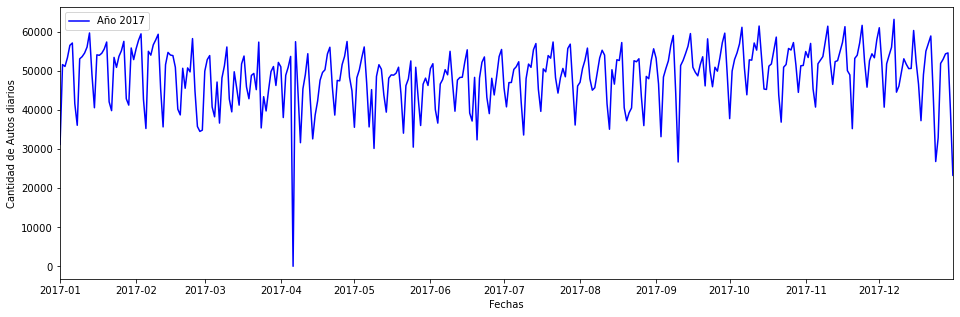

In [38]:
plt.figure(figsize=(16,5))

plt.plot(diario.index, diario.cantidad_pasos, label= "Año 2017", color = "b")
plt.ylabel("Cantidad de Autos diarios")
plt.xlabel("Fechas")
plt.xlim(dt.date(2017,1,1), dt.date(2017,12,31))
plt.legend()
plt.show()

- #### Año 2018

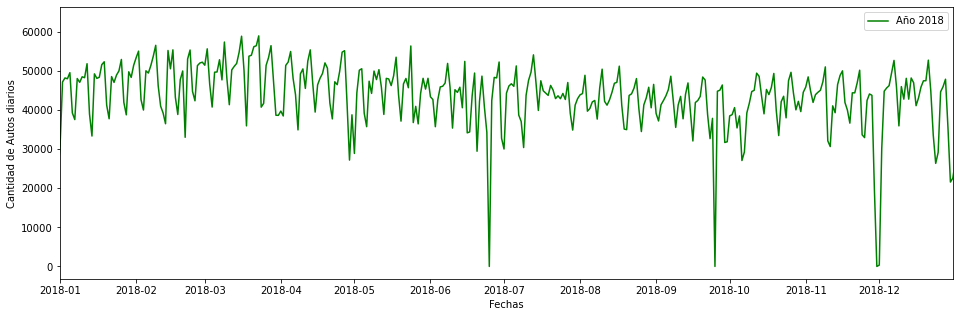

In [39]:
plt.figure(figsize=(16,5))

plt.plot(diario.index, diario.cantidad_pasos, label= "Año 2018", color = "g")
plt.ylabel("Cantidad de Autos diarios")
plt.xlabel("Fechas")
plt.xlim(dt.date(2018,1,1), dt.date(2018,12,31))
plt.legend()
plt.show()

- #### Año 2019

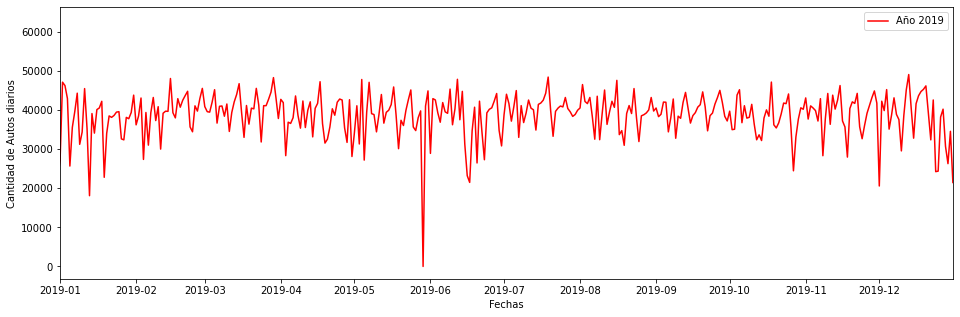

In [40]:
plt.figure(figsize=(16,5))

plt.plot(diario.index, diario.cantidad_pasos, label= "Año 2019", color = "r")
plt.ylabel("Cantidad de Autos diarios")
plt.xlabel("Fechas")
plt.xlim(dt.date(2019,1,1), dt.date(2019,12,31))
plt.legend()
plt.show()

## Observaciones Generales:

La serie presenta estacionalidad marcada llegando a las fechas festivas *(fin de año)*. La misma presenta patrones cícliclos, que se repiten pero no en el mismo tiempo.

Los picos negativos son ocasionados por situaciones extraordinarias. Es decir, los datos registrados son correctos, ya que debido a las circunstancias previamente enunciadas que afectaron la movilidad en la autopista Illia , solo **EFECTIVO** registró fuertes bajas en su conteo diario de vehículos.

Se procederá interpolando los *Valores Atípicos* usando el método más amigable para obtener una serie  apta para el modelado. Luego, se descompone la serie para evaluar su componentes, estudiar sus autocorrelaciones y probar distintos resampleos. 

Para interpolar los **Valores Atípicos** se seleccionan solo las fechas que presentaron valores inferiores a los registros de 10000 vehículos diarios. Se elige esta opción porque los otros días que registraron menos de 20000 autos diarios *(con Efectivo como método de pago)* se debieron a las conferencias de la **cumbre del G20 realizada en la Ciudad de Buenos Aires**. Debido a esto, las autopistas se vieron afectadas en su flujo diario de vehículos.

## Interpolando Valores Atípicos

In [41]:
diario1 = diario.copy()

diario1[(diario1.cantidad_pasos <= 10000)] = np.NaN

print(diario1.shape)

print(diario1.isna().sum())

diario1= diario1.interpolate(method='spline', order=2)

print(diario1.isna().sum())

(1095, 1)
cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


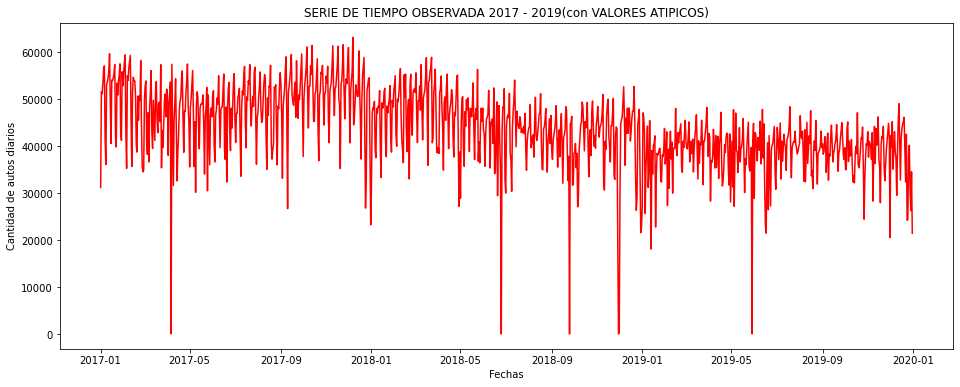

In [42]:
plt.figure(figsize=(16,6))

plt.plot(diario.index, diario.cantidad_pasos, color="r")
plt.title("SERIE DE TIEMPO OBSERVADA 2017 - 2019(con VALORES ATIPICOS)")
plt.ylabel("Cantidad de autos diarios")
plt.xlabel("Fechas")
plt.show()

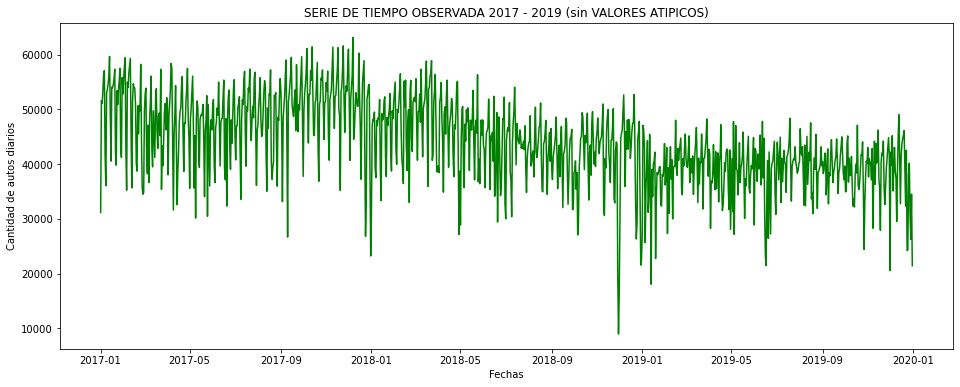

In [43]:
plt.figure(figsize=(16,6))

plt.plot(diario1.index, diario1.cantidad_pasos, color="g")
plt.title("SERIE DE TIEMPO OBSERVADA 2017 - 2019 (sin VALORES ATIPICOS)")
plt.ylabel("Cantidad de autos diarios")
plt.xlabel("Fechas")
plt.show()

El método por defecto de interpolación presenta resultados aceptables al momento de tratar los *Valores Atípicos*, sin embargo, muestra un día de los registrados por debajo de 10000 y luego, se prouncian significativamente los demás picos negativos. 

Se opta en este caso por estudiar por fuera del dataset distintos métodos de interpolación para evaluar cuál resulta más adecuado para este enfoque. 

In [44]:
diario2 = diario.copy()

diario2[(diario2.cantidad_pasos <= 10000)] = np.NaN

print(diario2.shape)

print(diario2.isna().sum())

diario2= diario2.interpolate(method='nearest', order=2)

print(diario2.isna().sum())

(1095, 1)
cantidad_pasos    6
dtype: int64
cantidad_pasos    0
dtype: int64


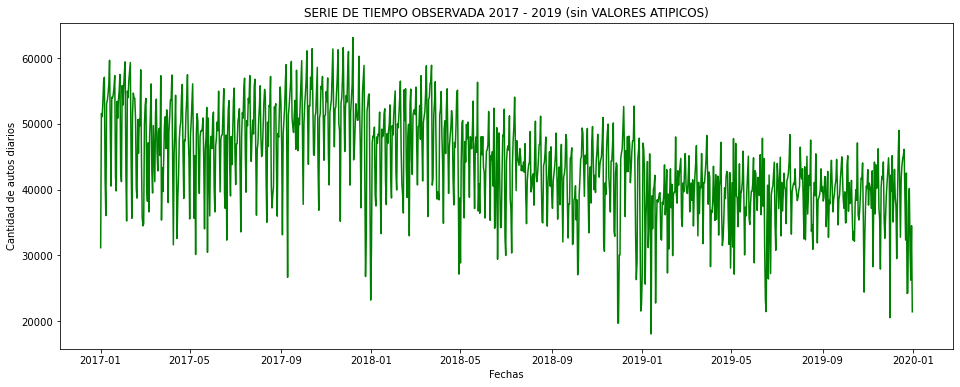

In [45]:
plt.figure(figsize=(16,6))

plt.plot(diario2.index, diario2.cantidad_pasos, color="g")
plt.title("SERIE DE TIEMPO OBSERVADA 2017 - 2019 (sin VALORES ATIPICOS)")
plt.ylabel("Cantidad de autos diarios")
plt.xlabel("Fechas")
plt.show()

Luego de investigar diferentes técnicas de interpolación, se concluye que el método **nearest** es el mas apropiado para series de tiempo que presentan este tipo de registros inconsistenes en su observación. 

Comparando el método tradicional con el método **nearest**, se evidencia que el último es el más apropiado y genera una mejor interpolación de Valores Atípicos.

*Se procede con el desarollo del proyecto al haber obtenido una serie apta para el modelado luego de aplicar los métodos de interpolación.*

A continuación se estudiará la serie en distintas frecuencias, empezando por su representación gráfica, siguiendo con la aplicación de funciones y finalmente, evaluar si las mismas pueden aportar mayor información o una mejor representación de la serie para su modelado que en su estado actual - *frecuencia diaria*.

## Estudiando la tendencia negativa de la serie:

La serie, luego de mediados del año *2018*, empieza a registrar una tendencia negativa que se pronuncia al finalizar el mismo año y se mantiene de esta manera a lo largo de todo el *2019*. Siguendo las indicaciones propuestas al principio, se estudiarán los distintos metodos de pago, con el fin de explicar esta tendencia. Se infiere que hubo una migración hacia otros métodos de pago através de los años, lo cual podría explicar por qué desciende el conteo de autos que pagan con *EFECTIVO*.

Sin embargo, también existe la probabilidad de que se hayan habilitado nuevas rutas para facilitar el tránsito en la ciudad de Buenos Aires, ocasionando la disminución del paso de vehículos por la autopista en cuestión.  

**Para poder observar explicar esta frecuencia negativa, el Análisis Exploratorio de Datos se realizará en frecuencia anual, dado que se busca explicar por qué el método de pago EFECTIVO desciende tan drásticamente en el ultimo año.**

Instancio los años observados para estación Illia y luego para EFECTIVO:

In [46]:
data_2017_illia = data_2017[data_2017.estacion == "Illia"]
data_2018_illia = data_2018[data_2018.estacion == "Illia"]
data_2019_illia = data_2019[data_2019.estacion == "Illia"]

In [47]:
#Función de StackOverflow: Dado un Dataframe y una Variable, busca el value_count de la variable instanciado a un objeto.
##Devuelve ese objeto dentro del DataFrame.

def table (df, var): 
    a = df[var].value_counts()
    return pd.DataFrame(a)

In [48]:
dataframe_pagos = pd.concat([(table(data_2017_illia, "forma_pago")),
                  (table(data_2018_illia, "forma_pago")),
                  (table(data_2019_illia, "forma_pago"))],
                axis= 1)

dataframe_pagos.columns = ["Pagos-2017", "Pagos-2018", "Pagos-2019"]

dataframe_pagos

,Pagos-2017,Pagos-2018,Pagos-2019
EFECTIVO,104230.0,99996.0,34643.0
TELEPASE,79903.0,89921.0,34788.0
EXENTO,39201.0,37498.0,29204.0
INFRACCION,24526.0,29459.0,24015.0
TARJETA DISCAPACIDAD,22145.0,19191.0,NaN
NO COBRADO,21881.0,23454.0,21344.0
MONEDERO,14.0,NaN,NaN
T. DISCAPACIDAD,NaN,NaN,17139.0


Luego de utilizar la función de StackOverflow para obtener un dataframe mostrando las formas de pago agrupadas por sus valores, se puede evidenciar de manera más clara que **EFECTIVO** era la forma más utilizada en el año 2017, presentando un pequeño declive en el año 2018, al contrario del **TELEPASE**, que presenta un amplio crecimiento.

Llegando a fines del 2018 y principios del 2019, solo **EFECTIVO** desciende de una manera abrupta, esto explica por qué la serie presenta esta tendencia negativa tan marcada. Es de destacar que también el conteo disminuye de manera significativa, lo cual puede deberse a lo anteriormente mencionado sobre la apertura de nuevas rutas para facilitar el tránsito en la ciudad de *Buenos Aires.*

Después de concluir que se migró a nuevas formas  de pago, se busca entender por qué el conteo de autos desciende de tal manera a través del último año observado.

In [49]:
conteo_vehiculos= pd.concat([(table(data_2017_illia, "tipo_vehiculo")),
                  (table(data_2018_illia, "tipo_vehiculo")),
                  (table(data_2019_illia, "tipo_vehiculo"))],
                axis= 1)

conteo_vehiculos.columns = ["Vehiculos-2017", "Vehiculos-2018", "Vehiculos-2019"]

conteo_vehiculos

,Vehiculos-2017,Vehiculos-2018,Vehiculos-2019
Pesado,161166,163619,60272
Liviano,130734,135900,100861


Se puede observar que el conteo de vehiculos pesados desciende de manera abrupta en el último año. Para explicar esto, recurrimos a la búsqueda de información por fuera del dataset para sustentar este hecho. Previamente se menciona la construcción del paseo *"El Bajo"* como una posible opción. 

En los primero años observados, los **vehículos pesados** generaban un mayor conteo que los **livianos**. A continuación se relacionan algunas noticias sobre la construcción del **Paseo del Bajo**:

- https://www.ausa.com.ar/novedades/paseodelbajo/ (Mayo - 2019)

- https://www.fadeeac.org.ar/el-paseo-del-bajo-ya-esta-abierto-al-transito/ (Mayo - 2019)

- https://www.acyaglobal.com/es/el-paseo-del-bajo/


Efectivamente, la apertura de este paso ocasionó una gran disminución en el conteo de vehículos pesados que transitaban porla autopista Illia. Esta medida generó un gran impacto en la medición diaria de vehículos, especialmente en su formato solo *EFECTIVO*.

## Estudiando distintas Frecuencias:

- ### Frecuencia Semanal

In [50]:
semanal_sum = diario2.resample("W").sum()

semanal_mean = diario2.resample("W").mean()

In [51]:
semanal_sum.head()

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-08,347212.0
2017-01-15,366413.0
2017-01-22,357215.0
2017-01-29,354581.0


In [52]:
semanal_sum.tail()

,cantidad_pasos
fecha,
2019-12-08,282891.0
2019-12-15,272960.0
2019-12-22,292881.0
2019-12-29,226390.0
2020-01-05,55970.0


In [53]:
semanal_mean.head()

,cantidad_pasos
fecha,
2017-01-01,31183.000000
2017-01-08,49601.714286
2017-01-15,52344.714286
2017-01-22,51030.714286
2017-01-29,50654.428571


In [54]:
semanal_mean.tail()

,cantidad_pasos
fecha,
2019-12-08,40413.000000
2019-12-15,38994.285714
2019-12-22,41840.142857
2019-12-29,32341.428571
2020-01-05,27985.000000


In [55]:
semanal_sum.describe()

,cantidad_pasos
count,158.000000
mean,304306.816456
std,46092.962139
min,31183.000000
25%,276604.500000
50%,307243.000000
75%,335333.000000
max,377832.000000


In [56]:
semanal_mean.describe()

,cantidad_pasos
count,158.000000
mean,43768.083183
std,5295.934963
min,27985.000000
25%,39514.928571
50%,43891.857143
75%,47904.714286
max,53976.000000


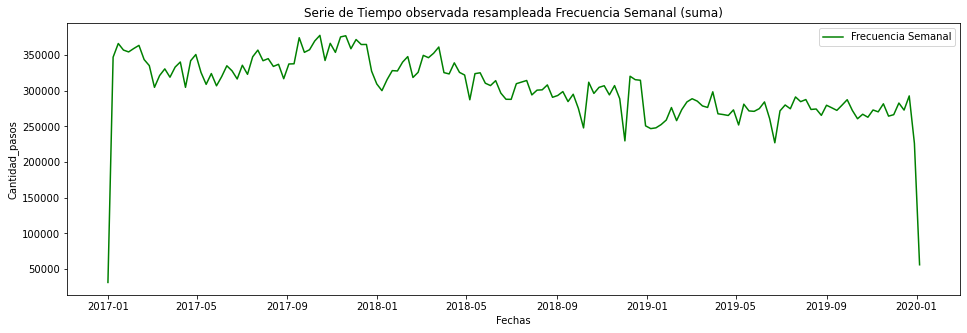

In [57]:
plt.figure(figsize=(16,5))

plt.plot(semanal_sum.index, semanal_sum.cantidad_pasos, label = "Frecuencia Semanal", color = "g")
plt.xlabel("Fechas")
plt.ylabel("Cantidad_pasos")
plt.title("Serie de Tiempo observada resampleada Frecuencia Semanal (suma)")
plt.legend()
plt.show()

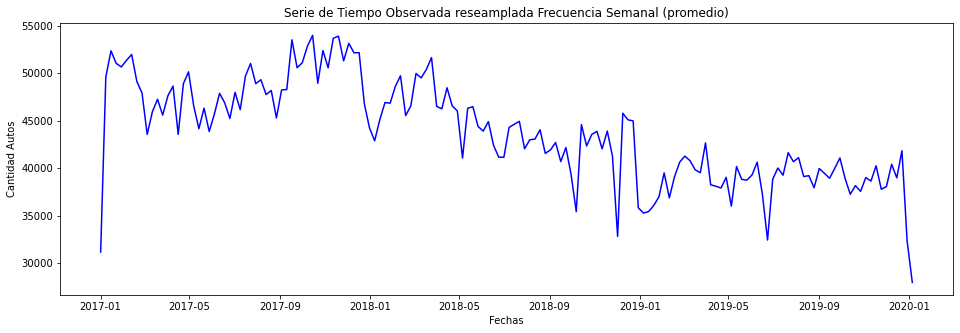

In [58]:
plt.figure(figsize=(16,5))

plt.plot(semanal_mean.index, semanal_mean.cantidad_pasos, label="Frecuencia Semanal", color = "b")
plt.xlabel("Fechas")
plt.ylabel("Cantidad Autos")
plt.title("Serie de Tiempo Observada reseamplada Frecuencia Semanal (promedio)")
plt.show()

Al aplicar un resampleo de la serie a *Frecuencia Semanal*, el mejor enfoque es utilizar el promedio *(mean)*, dado que produce valores mucho más parecidos a los medidos en la Frecuencia Diaria. Sin embargo, es evidente que la serie se vuelve menos amigable visualmente y presenta patrones menos marcados, no solo estacionarios sino cíclicos. 

Se procede a estudiar la serie en su *Frecuencia Mensual* y en caso de que esta resulte de menor impacto informativo que la de Frecuencia Semanal, se continuará estudiando la serie en su *Frecuencia Diaria*, para luego descomponer la misma y evaluar sus componentes por separado y definir si es una Serie con Descomposición **Aditiva** o **Multiplicativa.**

- ### Frecuencia Mensual

In [59]:
mensual_sum = diario2.resample("M").sum()

mensual_mean = diario2.resample("M").mean()

In [60]:
mensual_sum.head()

,cantidad_pasos
fecha,
2017-01-31,1565260.0
2017-02-28,1363113.0
2017-03-31,1451214.0
2017-04-30,1427600.0
2017-05-31,1407136.0


In [61]:
mensual_sum.tail()

,cantidad_pasos
fecha,
2019-08-31,1223990.0
2019-09-30,1194001.0
2019-10-31,1177647.0
2019-11-30,1184560.0
2019-12-31,1151645.0


In [62]:
mensual_mean.head()

,cantidad_pasos
fecha,
2017-01-31,50492.258065
2017-02-28,48682.607143
2017-03-31,46813.354839
2017-04-30,47586.666667
2017-05-31,45391.483871


In [63]:
mensual_mean.tail()

,cantidad_pasos
fecha,
2019-08-31,39483.548387
2019-09-30,39800.033333
2019-10-31,37988.612903
2019-11-30,39485.333333
2019-12-31,37149.838710


In [64]:
mensual_sum.describe()

,cantidad_pasos
count,3.600000e+01
mean,1.335569e+06
std,1.453126e+05
min,1.103086e+06
25%,1.220247e+06
50%,1.336892e+06
75%,1.433504e+06
max,1.597356e+06


In [65]:
mensual_mean.describe()

,cantidad_pasos
count,36.000000
mean,43917.601291
std,4683.627608
min,36871.709677
25%,39721.358333
50%,43224.483871
75%,47902.504032
max,52714.266667


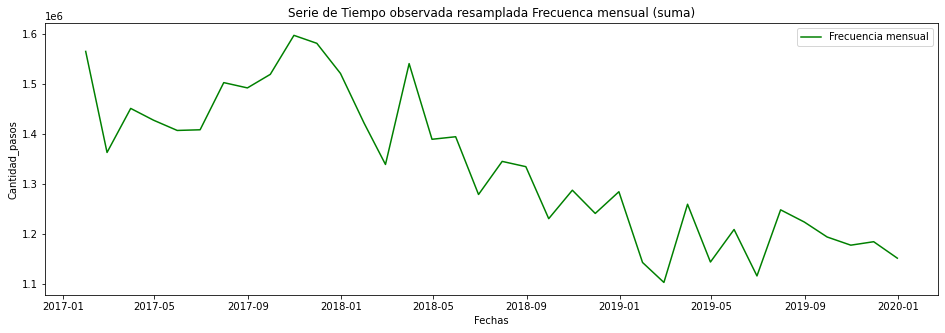

In [66]:
plt.figure(figsize=(16,5))

plt.plot(mensual_sum.index, mensual_sum.cantidad_pasos, label = "Frecuencia mensual", color = "g")
plt.xlabel("Fechas")
plt.ylabel("Cantidad_pasos")
plt.title("Serie de Tiempo observada resamplada Frecuenca mensual (suma)")
plt.legend()
plt.show()

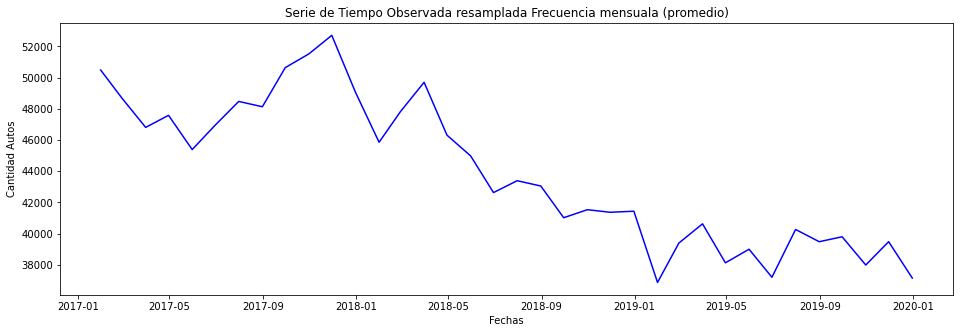

In [67]:
plt.figure(figsize=(16,5))

plt.plot(mensual_mean.index, mensual_mean.cantidad_pasos, label="Frecuencia mensual", color = "b")
plt.xlabel("Fechas")
plt.ylabel("Cantidad Autos")
plt.title("Serie de Tiempo Observada resamplada Frecuencia mensuala (promedio)")
plt.show()

Tal como se esperaba, la *Frecuencia Mensual* es menos amigable y más confusa para su intepretación. 

Dado que tratamos con un sistema de medición de *cantidad de pasos en la autopista Illia* diariamente, es normal que la mejor frecuencia para abordar su estudio sea **diaria**, ya que es la que mejor permite su visualización y modelado. 

Se procede ahora a estudiar las **Autocorrelaciones** de la Serie de Tiempo observada y por último, antes del modelado, estudiar la descomposición de la misma, siendo este el último paso en la confirmación de que la serie es apta para su modelado. 

De aquí en adelante, se continuará trabajando con la serie de tiempo observada en su *Frecuencia Diaria.*

## Estudiando Autocorrelaciones

In [68]:
nlags= 365 # 365 = Número de días en 1 año.
               
autocorr= stattools.acf(diario2, nlags= nlags)

In [69]:
autocorr.shape

(366,)

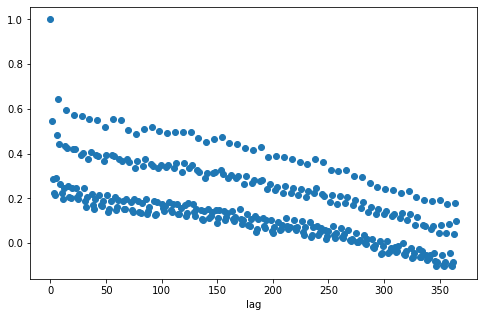

In [70]:
plt.figure(figsize = (8,5))

plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

plt.show()

In [71]:
nlags= 365*2 # 365 = Numero de días en 1 año.
               # 2 = Numero de años observados.

autocorr= stattools.acf(diario2, nlags= nlags)

In [72]:
autocorr.shape

(731,)

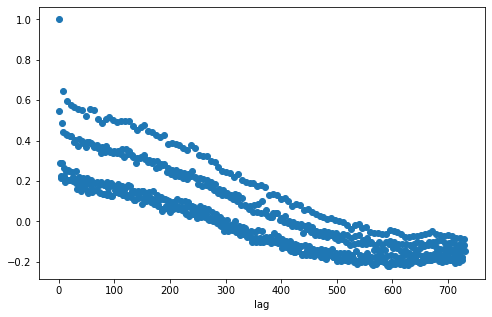

In [73]:
plt.figure(figsize = (8,5))

plt.scatter(np.arange(nlags+1), autocorr)
plt.xlabel('lag')

plt.show()

In [74]:
nlags= 365 * 3   # 365 = Numero de dias en 1 año.
               # 3 = Numero de años observados.

autocorr= stattools.acf(diario2, nlags= nlags)

In [75]:
autocorr.shape

(1095,)

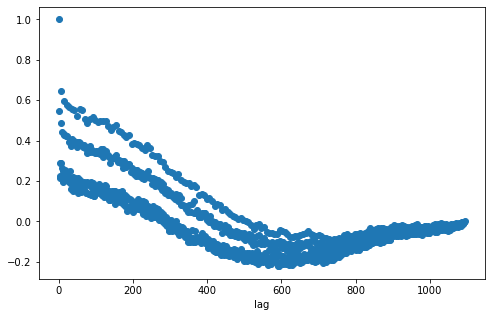

In [76]:
plt.figure(figsize = (8,5))

plt.scatter(np.arange(nlags), autocorr)
plt.xlabel('lag')

plt.show()

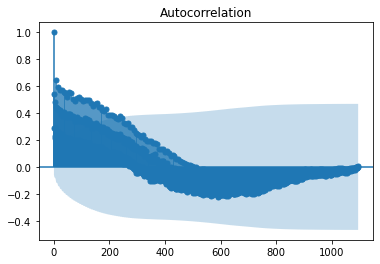

In [77]:
plot_acf(diario2, lags = np.arange((365*3)))

plt.show()

El estudio de las autocorrelaciones de los tres años observados en su frecuencia diaria demuestra que la serie guarda como *datos de interés* (aquellos fuera del area sombrada) a los primeros días registrados. El resto de datos que se encuentran dentro del area sombreada son aquellos intervalos de confianza que se que van a pasar.  

En este caso, la serie conserva una relación positiva en los primeros días observados, mientras que con el paso del tiempo, como es de esperarse, pierde esta relación positiva y se vuelve negativa con sigo misma mientras más tiempo pasa.

Llegando al final del Análisis Exploratorio de los Datos, ahora se procede a descomponer la serie para estudiar sus elementos por separado y graficando los mismos, con el fin de saber si presenta residuales del tipo **"White Noise"**, los cuales son los únicos aptos para el modelado y predicción.

## Descomponiendo la Serie de Tiempo

- ### Descomposición Additiva Diaria

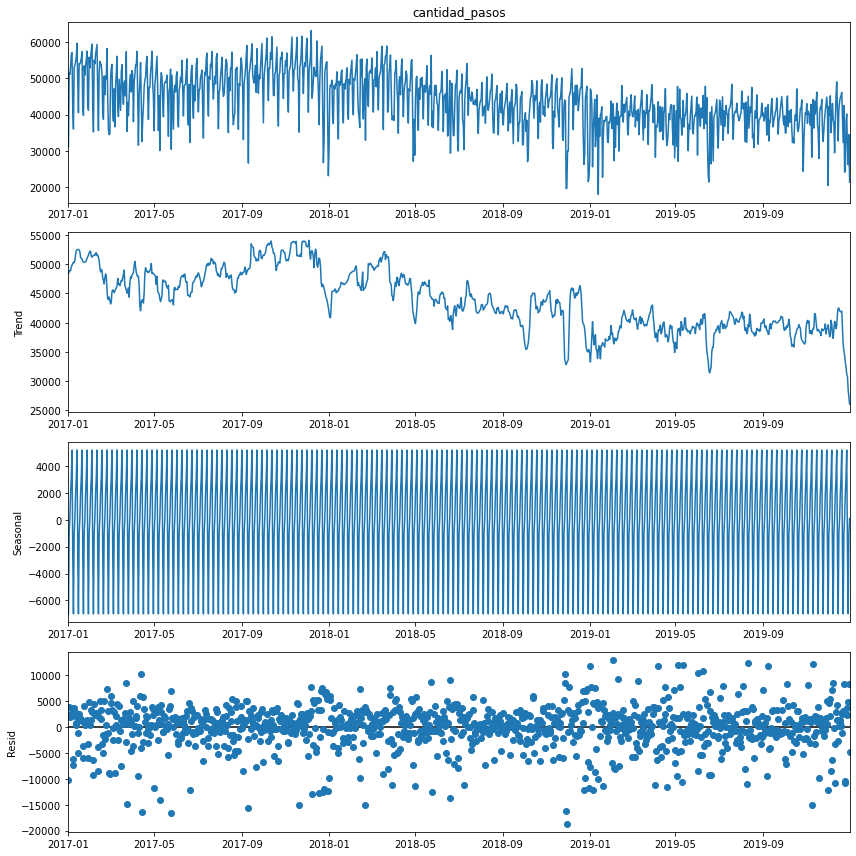

In [78]:
plt.rcParams['figure.figsize'] = [12,12]

deco_diaria = tsa.seasonal.seasonal_decompose(diario2.cantidad_pasos, model='additive',extrapolate_trend='freq')

deco_diaria.plot()
plt.show()

- Graficando los residuales

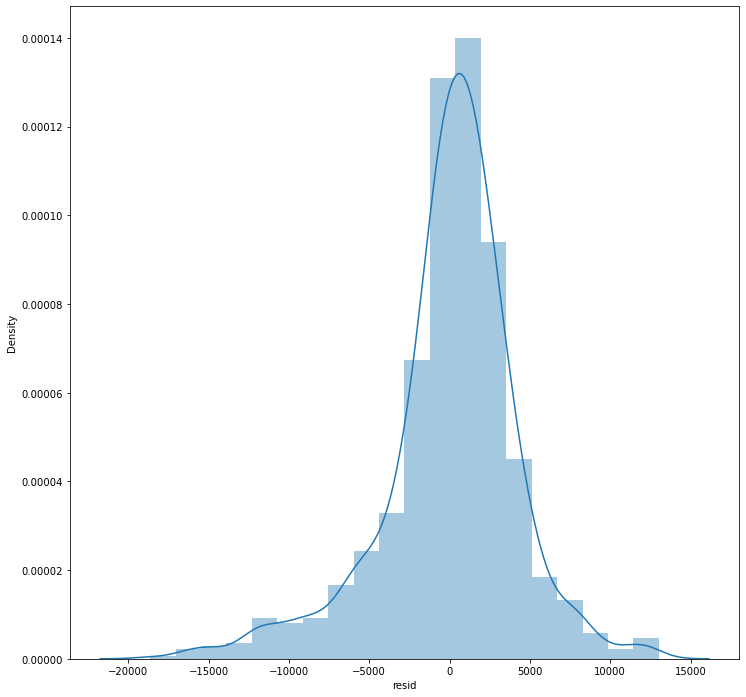

In [79]:
sns.distplot(deco_diaria.resid, bins=20)

plt.show()

- ### Descomposición Multiplicativa Diaria

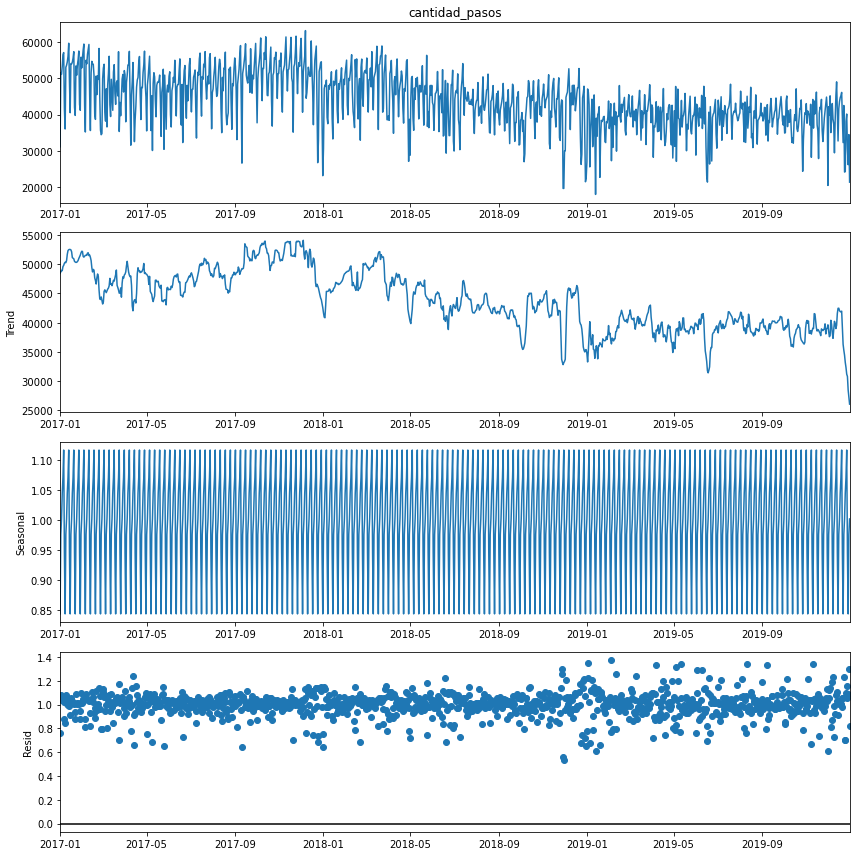

In [80]:
plt.rcParams['figure.figsize'] = [12,12]

deco_diaria1 = tsa.seasonal.seasonal_decompose(diario2.cantidad_pasos, model='multiplicative',extrapolate_trend='freq')

deco_diaria1.plot()
plt.show()

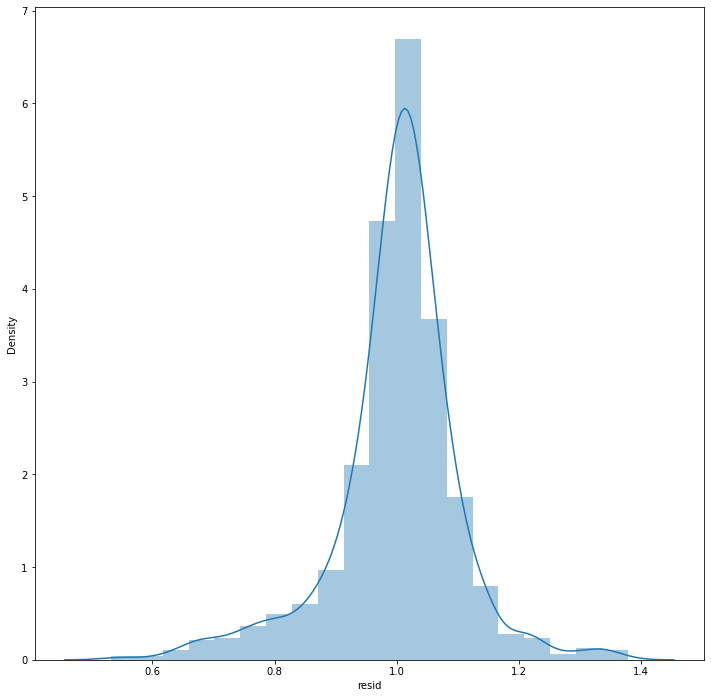

In [81]:
sns.distplot(deco_diaria1.resid, bins=20)

plt.show()

Luego de concluir el estudio de la descomposición de la serie, tanto en su modelo **Aditivo** como **Multiplicativo**, se observa que el primer gráfico muestra los datos como quedarían luego ser interpolados.

El segundo gráfico ofrece la tendencia de la serie para estudiarla de manera individual. Se puede apreciar de manera más detallada la disminución en el conteo diario de vehículos que efectúan su pago en **EFECTIVO**, generando así un incio de tendencia negativa en la serie.

Como se pudo explicar anteriormente, no solo los nuevos métodos de pago generaron que los vehículos dejaran de realizar su pago en **EFECTIVO** y comenzaran a utilizar el **TELEPASE**, sino que también muchos vehículos *(sobre todos los pesados)* comenzaron a transitar por el nuevo **Paseo El Bajo**, el cual estaba destinado a estos últimos para disminuir la frecuencia de vehículos que transitaban la autopista Illia, sobre todo en nada en horas picos.

Luego, el tercer gráfico representa la estacionalidad de la serie. Este es un gráfico completo, dado que obtenemos todos los registros de la serie correctamente observados.

Se concluye lo siguiente:

- En el estudio de la descomposición de la serie en su modelo **Multiplicativo**, los residuales son representados con un promedio fijo en 1. 
- Por otro lado, cuando estudiamos la descomposición de la serie en su modelo **Aditivo**, estos últimos son representados con un promedio fijo en 0, siendo este el resultado deseado.

Esto significa que la serie presenta **Residuales con "White Noise"**, los cuales poseen un promedio fijo en 0 con un comportamiento completamente aleatorio, siendo este el resultado deseado para proceder al modelado. 

*Los gráficos de los residuales a través de Histogramas otorgan una mejor visualización de la diferencia de residuales con media fija en 1 y 0.*

Luego de explorar la serie de Tiempo presentada, en sus distintas frecuencias, incluyendo y excluyendo sus **Valores Atípicos** y evaluar información por fuera del dataset para explicar algunas discrodancias *(como los registros negativos en varios días a lo largo de los 3 años observados)*, se concluye que la serie es apta para su modelado, dado que la misma presenta una estacionalidad marcada llegando al final de cada año. Además, muestra patrones cíclicos registrados mensualmente y un registro completamente aleatorio de sus residuales.

Los descensos en los registros se ven marcados principalmente por la creación de nuevas rutas de acceso para descongestionar el tráfico en la autipista Illia, especialmente para vehiculos de tipo **Pesado**. Adicionalmente, la inclusión de nuevos peajes con casillas de cobro automatizado, como el **Telepase**, que se volvieron cada vez más frecuentes y eficientes, dejaron atrás al antiguo método de pago **EFECTIVO**.

# Machine Learning

En esta sección, será necesario crear un modelo Benchmark para luego contrastarlo con los modelos elegidos y posteriormente predecir sobre el último trimestre del año 2019. 

Para esto, la *Frecuencia Semanal* será la ideal para predecir el flujo de la autopista en el año 2019 y luego, para su futura predicción en el año 2020, ya que en su frecuencia semanal se cuenta con menos instancias a entrenar y predecir, por lo que el estudio y modelado de la serie será mas eficiente para los algoritmos.

- ## Modelo Benchmark

Procedo a crear el modelo Benchmark, el cual será un promedio de los meses de Julio, Agosto y Septiembre del año 2019 en su **frecuencia semanal**, para predecir los meses de Octubre, Noviembre y Diciembre *(último trimestre 2019)*.

- Debido a que la serie observada se encuentra libre de Valores Atípicos, eligo la métrica de evaluación **RMSE**.
- Al mismo tiempo, utilizaré la función de Pandas *Rolling* para calcular el promedio los primeros 3 meses elegidos (12 semanas). Luego evaluaré y contrastaré con los resultados reales (observados).

### Resampleando a frecuencia Semanal:

In [82]:
semanal = diario2.resample("W").mean()

In [83]:
startdate_x = "2019-07-01"
endate_x = "2019-09-30"

startdate_y = "2019-10-01"
endate_y = "2019-12-31"

x = semanal[(semanal.index >= startdate_x) & (semanal.index <= endate_x)]


y = semanal[(semanal.index >= startdate_y) & (semanal.index <= endate_y)]

y_promedio = x.cantidad_pasos.rolling(window =1, center =True).mean()

benchmarkrmse = np.sqrt(metrics.mean_squared_error(y,y_promedio))

In [84]:
benchmarkrmse

2999.8287232635216

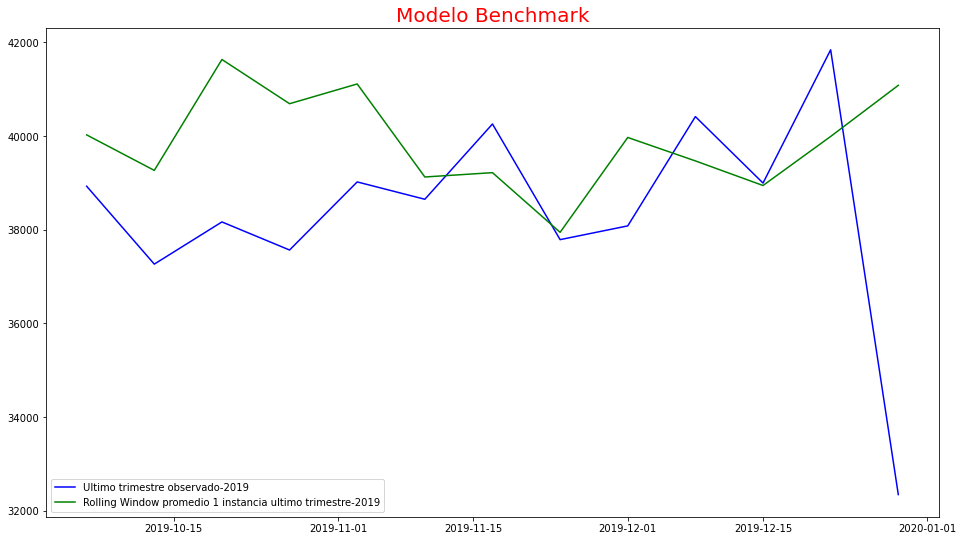

In [85]:
plt.figure(figsize=(16,9))


plt.plot(y.index, y.cantidad_pasos, label = "Ultimo trimestre observado-2019", color = "b")
plt.plot(y.index, y_promedio, label="Rolling Window promedio 1 instancia ultimo trimestre-2019",color="g")
plt.title("Modelo Benchmark", fontsize= 20, color = "r")
plt.legend()
plt.show()

Con un RMSE no muy elevado, pero para nada satisfactorio, el modelo **Benchmark** presenta un desempeño esperable. 

Ahora, se emplea un modelo de **RandomForestRegressor** para entrenar el modelo con la Serie de Tiempo Observada.

El lookback seleccionado será de 12. Este es el número de semanas que se utilizará para predecir el valor siguiente.

Luego, procederé a separar los datos en *train* y *test* de una forma adecuada. Para esto utilizaré 143 semanas para evaluar, el lookback y 12 para evaluar.

### Creando los datos:

In [86]:
senial = semanal.cantidad_pasos

In [87]:
look_back= 12 
n= senial.shape[0]
x= np.zeros((n - look_back - 1, look_back))
y= np.zeros(n - look_back - 1)

print(x.shape, y.shape)

(145, 12) (145,)


In [88]:
for i in range(x.shape[0]):
    
    x[i,:] = senial.iloc[i:i+look_back]
    y[i] = senial.iloc[i+look_back]

In [89]:
print(x, x.shape)
print(y, y.shape)

[[31183.         49601.71428571 52344.71428571 ... 43558.28571429
  45927.71428571 47256.28571429]
 [49601.71428571 52344.71428571 51030.71428571 ... 45927.71428571
  47256.28571429 45583.28571429]
 [52344.71428571 51030.71428571 50654.42857143 ... 47256.28571429
  45583.28571429 47613.85714286]
 ...
 [39989.57142857 41081.14285714 38926.14285714 ... 37785.71428571
  38079.28571429 40413.        ]
 [41081.14285714 38926.14285714 37262.85714286 ... 38079.28571429
  40413.         38994.28571429]
 [38926.14285714 37262.85714286 38163.85714286 ... 40413.
  38994.28571429 41840.14285714]] (145, 12)
[45583.28571429 47613.85714286 48639.57142857 43558.85714286
 48889.28571429 50135.14285714 46553.57142857 44153.14285714
 46320.         43864.85714286 45705.28571429 47878.14285714
 46874.57142857 45235.85714286 47985.71428571 46165.57142857
 49681.42857143 51022.28571429 48891.42857143 49309.14285714
 47749.28571429 48177.57142857 45283.85714286 48237.
 48276.14285714 53502.85714286 50571.285

In [90]:
n_train = 143 - look_back        
n_test = 12                    

n_total = n_train + n_test

length_total = n_train + n_test + look_back

x_train = x[:n_train,:]
y_train = y[:n_train]
print(x_train.shape, y_train.shape)

x_test = x[n_train:n_train+n_test,:]
y_test = y[n_train:n_train+n_test]
print(x_test.shape, y_test.shape)

(131, 12) (131,)
(12, 12) (12,)


## Modelo RandomForestRegressor:

In [91]:
random_model= RandomForestRegressor(random_state=42)

In [92]:
random_model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

Según lo estudiado, **TimeSeriesSplit** es el mejor método, dado que no afecta el orden en el cual se encuentran indexados los datos y esto es vital para las Series de Tiempo.

In [93]:
timeseries_split= TimeSeriesSplit(n_splits=2)

In [94]:
best_score_train = abs(cross_val_score(
    random_model, x_train, y_train, cv=timeseries_split, scoring="neg_root_mean_squared_error")
)
best_score_test = abs(cross_val_score(
    random_model, x_test, y_test, cv=timeseries_split,  scoring="neg_root_mean_squared_error"))

print("Mejor Score en Train (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_train.mean(), best_score_train.std()))

print("Mejor Score en Test (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_test.mean(), best_score_test.std()))

Mejor Score en Train (CV = 10) 3599.40 (+/- 286.91)
Mejor Score en Test (CV = 10) 1304.40 (+/- 397.74)


In [95]:
y_train_pred_randomf = random_model.predict(x_train)
y_test_pred_randomf = random_model.predict(x_test)

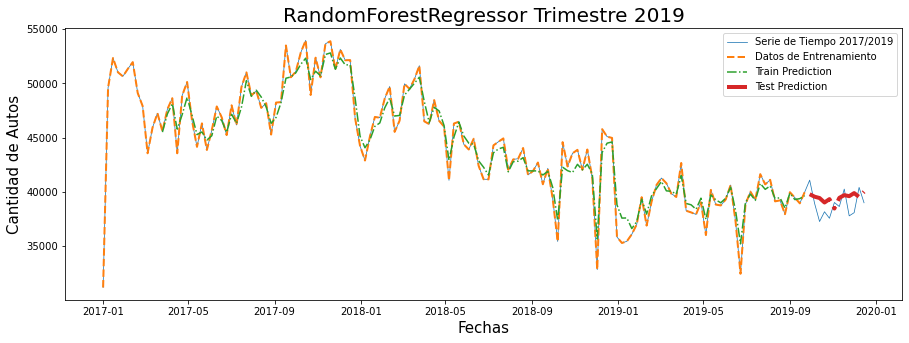

RandomForest Train
RMSE resultado -Train:  1036.1396144944501
RandomForest Test
RMSE resultado Test:  1299.7855956335675


In [96]:
plt.figure(figsize=(15,5))


plt.plot(senial.index[:length_total], senial[:length_total], lw = 0.75, label = "Serie de Tiempo 2017/2019")
plt.plot(senial.index[:n_train + look_back], senial[:n_train + look_back], '--', lw= 2, label = 'Datos de Entrenamiento')
plt.plot(senial.index[look_back: look_back + n_train], y_train_pred_randomf, '-.', label = 'Train Prediction')
plt.plot(senial.index[n_train+look_back: length_total], y_test_pred_randomf, '-.', lw = 4, label = 'Test Prediction')

plt.title("RandomForestRegressor Trimestre 2019", color= 'k', fontsize=20)
plt.xlabel('Fechas', fontsize=15)
plt.ylabel('Cantidad de Autos', fontsize=15)


plt.legend()
plt.show()

rmse_train_randomf = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_randomf))

rmse_test_randomf = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_randomf))

print("RandomForest Train")
print("RMSE resultado -Train: ", rmse_train_randomf)


print("RandomForest Test")
print("RMSE resultado Test: ", rmse_test_randomf)


El resultado del **RandomForest** es óptimo en relación al Benchmark, el cual presenta mejoras notables. Ahora, se preocede a realizar un **RandomizedSearchCV** o **GridSearchCV** con el fin de verificar si los resultados mejoran luego de mejorar los hiperparámetros.

In [97]:
param_grid = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(2,10)],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4, 6]}


model= GridSearchCV(random_model,
                   param_grid,
                   cv= timeseries_split,
                   scoring= 'neg_root_mean_squared_error',
                   verbose= 3)

In [98]:
model.fit(x_train,y_train)

Fitting 2 folds for each of 864 candidates, totalling 1728 fits
[CV] max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=-4410.717, total=   0.0s
[CV] max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=-3548.222, total=   0.0s
[CV] max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=-4231.244, total=   0.1s
[CV] max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=-3828.801, total=   0.1s
[CV] max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=-4123.539, total=   0.2s
[CV] max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=-4022.094, total=   0.2s
[CV] max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-4410.717, total=   0.0s
[CV] max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-3548.

[CV]  max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=-4357.262, total=   0.2s
[CV] max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20, score=-4290.331, total=   0.0s
[CV] max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20, score=-4213.070, total=   0.0s
[CV] max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=-4285.505, total=   0.1s
[CV] max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=-4293.604

[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-4244.368, total=   0.0s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-4247.299, total=   0.1s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=-4175.472, total=   0.1s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=-4353.695, total=   0.1s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=-4154.60

[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=-4489.885, total=   0.1s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=-4265.757, total=   0.2s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=-4512.703, total=   0.2s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=20 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=20, score=-4416.050, total=   0.0s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=20 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=20, score=-4454.

[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=-4154.606, total=   0.2s
[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=-4424.625, total=   0.2s
[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=20 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=20, score=-4244.368, total=   0.0s
[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=20 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=20, score=-4247.299, total=   0.0s
[CV] max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=50 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=50, score=-4176.6

[CV]  max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=-4512.703, total=   0.2s
[CV] max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=20 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=20, score=-4416.050, total=   0.0s
[CV] max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=20 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=20, score=-4454.144, total=   0.0s
[CV] max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=-4318.493, total=   0.1s
[CV] max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=2, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=-4489.885

[CV]  max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=50, score=-3224.256, total=   0.1s
[CV] max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=100 
[CV]  max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=100, score=-3882.027, total=   0.2s
[CV] max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=100 
[CV]  max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=100, score=-3282.595, total=   0.2s
[CV] max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, score=-4119.038, total=   0.0s
[CV] max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, score=-3666.

[CV]  max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=100, score=-4040.216, total=   0.2s
[CV] max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=20 
[CV]  max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=20, score=-4233.512, total=   0.0s
[CV] max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=20 
[CV]  max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=20, score=-4230.888, total=   0.0s
[CV] max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50, score=-4236.803, total=   0.1s
[CV] max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  max_depth=3, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50, score=-4126.949

[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=-4137.964, total=   0.1s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=-4020.870, total=   0.2s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=-4209.235, total=   0.2s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-3998.156, total=   0.1s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-4003.

[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=100, score=-4222.463, total=   0.2s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=100 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=100, score=-4319.649, total=   0.2s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=20 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=20, score=-4318.776, total=   0.0s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=20 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=20, score=-4536.109, total=   0.1s
[CV] max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=-4194.5

[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=-4209.235, total=   0.2s
[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-3998.156, total=   0.0s
[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-4003.963, total=   0.0s
[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=-3999.814, total=   0.1s
[CV] max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=-4122.566

[CV]  max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=20, score=-4536.109, total=   0.0s
[CV] max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=-4194.593, total=   0.1s
[CV] max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=-4428.149, total=   0.1s
[CV] max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=100, score=-4222.463, total=   0.2s
[CV] max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=100 
[CV]  max_depth=3, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=100, score=-4319.

[CV]  max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=-3736.705, total=   0.1s
[CV] max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=-3814.961, total=   0.2s
[CV] max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=-3849.740, total=   0.2s
[CV] max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=20 
[CV]  max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-4052.306, total=   0.1s
[CV] max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=20 
[CV]  max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-3810.

[CV]  max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=100, score=-4178.025, total=   0.2s
[CV] max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=20 
[CV]  max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=20, score=-4233.512, total=   0.1s
[CV] max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=20 
[CV]  max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=20, score=-4322.065, total=   0.0s
[CV] max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=50 
[CV]  max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=50, score=-4236.803, total=   0.1s
[CV] max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=50 
[CV]  max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=50, score=-4175.822

[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-4257.938, total=   0.1s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=50 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=50, score=-3956.978, total=   0.1s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=50 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=50, score=-4189.972, total=   0.1s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=100 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=100, score=-4032.903, total=   0.2s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=100 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=100, score=-4244.

[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=50, score=-4188.466, total=   0.1s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=50 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=50, score=-4438.016, total=   0.1s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=100 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=100, score=-4219.387, total=   0.2s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=100 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=100, score=-4302.425, total=   0.2s
[CV] max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=-3674.

[CV]  max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=50, score=-4189.972, total=   0.1s
[CV] max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100, score=-4032.903, total=   0.2s
[CV] max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100, score=-4244.821, total=   0.2s
[CV] max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20, score=-4259.023, total=   0.0s
[CV] max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=20, score=-4344.

[CV]  max_depth=4, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=100, score=-4219.387, total=   0.2s
[CV] max_depth=4, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=100 
[CV]  max_depth=4, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=100, score=-4302.425, total=   0.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=-4066.307, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=-3310.860, total=   0.0s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=-4004.5

[CV]  max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20, score=-4086.446, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20, score=-4194.912, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=-4140.075, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=-4058.069, total=   0.1s
[CV] max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=-4085.68

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=-3658.131, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=-3750.643, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=-3799.710, total=   0.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-3793.634, total=   0.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-3817.

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=-4324.547, total=   0.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=20, score=-4217.663, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=20, score=-4345.327, total=   0.0s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=-4155.167, total=   0.1s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=-4295.588

[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=-3738.708, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=-3789.131, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=-3818.711, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=20 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=20, score=-3841.929, total=   0.0s
[CV] max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=20 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=20, score=-3952.

[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=-4324.547, total=   0.2s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=20 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=20, score=-4217.663, total=   0.0s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=20 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=20, score=-4345.327, total=   0.0s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=-4155.167, total=   0.1s
[CV] max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=-4295.588

[CV]  max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=50, score=-3265.231, total=   0.1s
[CV] max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=100 
[CV]  max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=100, score=-3863.070, total=   0.2s
[CV] max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=100 
[CV]  max_depth=6, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=100, score=-3286.733, total=   0.2s
[CV] max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, score=-4003.294, total=   0.0s
[CV] max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=20, score=-3844.

[CV]  max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=7, n_estimators=100, score=-4117.502, total=   0.2s
[CV] max_depth=6, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=20 
[CV]  max_depth=6, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=20, score=-4233.512, total=   0.1s
[CV] max_depth=6, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=20 
[CV]  max_depth=6, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=20, score=-4322.065, total=   0.0s
[CV] max_depth=6, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  max_depth=6, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50, score=-4236.803, total=   0.1s
[CV] max_depth=6, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  max_depth=6, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=50, score=-4175.822

[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=-4115.728, total=   0.1s
[CV] max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=-3903.247, total=   0.2s
[CV] max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=-4196.306, total=   0.2s
[CV] max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-3789.710, total=   0.0s
[CV] max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-4160.

[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=100, score=-4301.115, total=   0.2s
[CV] max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=20 
[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=20, score=-4318.776, total=   0.1s
[CV] max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=20 
[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=20, score=-4532.164, total=   0.1s
[CV] max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=-4188.466, total=   0.1s
[CV] max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  max_depth=6, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=-4437.681

[CV]  max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=-4139.051, total=   0.1s
[CV] max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=-3963.021, total=   0.2s
[CV] max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=-4204.414, total=   0.2s
[CV] max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=20 
[CV]  max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-3952.634, total=   0.0s
[CV] max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=20 
[CV]  max_depth=6, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-4180.

[CV]  max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=100, score=-4219.387, total=   0.2s
[CV] max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=100 
[CV]  max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=5, n_estimators=100, score=-4301.115, total=   0.2s
[CV] max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=20 
[CV]  max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=20, score=-4318.776, total=   0.0s
[CV] max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=20 
[CV]  max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=20, score=-4532.164, total=   0.0s
[CV] max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=50 
[CV]  max_depth=6, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=50, score=-4188.4

[CV]  max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=-3858.751, total=   0.2s
[CV] max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=20 
[CV]  max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-4056.732, total=   0.1s
[CV] max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=20 
[CV]  max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-3768.726, total=   0.1s
[CV] max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=50 
[CV]  max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=50, score=-3960.035, total=   0.1s
[CV] max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=50 
[CV]  max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=7, n_estimators=50, score=-3717.955

[CV]  max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=50, score=-4175.822, total=   0.1s
[CV] max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=100 
[CV]  max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=100, score=-4155.135, total=   0.2s
[CV] max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=100 
[CV]  max_depth=7, max_features=auto, min_samples_leaf=6, min_samples_split=7, n_estimators=100, score=-4178.925, total=   0.2s
[CV] max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=-3677.616, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=-3583.

[CV]  max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=7, n_estimators=100, score=-4282.843, total=   0.2s
[CV] max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20, score=-4217.663, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20 
[CV]  max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=20, score=-4346.174, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=-4155.167, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50 
[CV]  max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=-4300.092

[CV]  max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=-3608.559, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50 
[CV]  max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50, score=-3638.066, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=-3730.524, total=   0.2s
[CV] max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=-3771.204, total=   0.2s
[CV] max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  max_depth=7, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-3876.

[CV]  max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50, score=-4300.092, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=-4237.784, total=   0.2s
[CV] max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, score=-4325.850, total=   0.2s
[CV] max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20, score=-4217.663, total=   0.0s
[CV] max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  max_depth=7, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=20, score=-4346.

[CV]  max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=-3886.374, total=   0.2s
[CV] max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, score=-3301.573, total=   0.2s
[CV] max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-4019.783, total=   0.0s
[CV] max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=20, score=-3272.435, total=   0.0s
[CV] max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=-3988.0

[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20, score=-4086.446, total=   0.0s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=20, score=-4190.824, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=-4140.075, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50, score=-4055.931, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100 
[CV]  max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=-4085.68

[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50, score=-3800.047, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=-3758.972, total=   0.2s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100, score=-3852.602, total=   0.2s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=20 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=20, score=-3854.765, total=   0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=20 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=20, score=-3937.

[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100, score=-4325.850, total=   0.2s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=20 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=20, score=-4217.663, total=   0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=20 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=20, score=-4346.174, total=   0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=-4155.167, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=50 
[CV]  max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=-4300.092

[CV]  max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=50, score=-3907.675, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=100, score=-3780.127, total=   0.2s
[CV] max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=100 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=1, min_samples_split=7, n_estimators=100, score=-4000.223, total=   0.2s
[CV] max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=20, score=-3781.523, total=   0.0s
[CV] max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=20 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=20, score=-4118.

[CV]  max_depth=8, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=100, score=-4325.850, total=   0.2s
[CV] max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=20 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=20, score=-4318.776, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=20 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=20, score=-4532.164, total=   0.0s
[CV] max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50, score=-4188.466, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50 
[CV]  max_depth=8, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=50, score=-4437.681

[CV] max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50 
[CV]  max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=50, score=-3746.581, total=   0.1s
[CV] max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=-3822.549, total=   0.2s
[CV] max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100 
[CV]  max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100, score=-3864.249, total=   0.3s
[CV] max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-3964.243, total=   0.0s
[CV] max_depth=9, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_dep

[CV]  max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=100, score=-4178.925, total=   0.2s
[CV] max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=20 
[CV]  max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=20, score=-4233.512, total=   0.0s
[CV] max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=20 
[CV]  max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=20, score=-4322.065, total=   0.0s
[CV] max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=-4236.803, total=   0.1s
[CV] max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, max_features=auto, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=-4175.822

[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-3802.769, total=   0.0s
[CV] max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20 
[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=20, score=-4143.361, total=   0.0s
[CV] max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=-3860.179, total=   0.1s
[CV] max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50 
[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=-4131.556, total=   0.1s
[CV] max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=-3958.41

[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=50, score=-4437.681, total=   0.1s
[CV] max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=100, score=-4219.387, total=   0.3s
[CV] max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=100, score=-4301.115, total=   0.2s
[CV] max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=20 
[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=20, score=-4318.776, total=   0.1s
[CV] max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=20 
[CV]  max_depth=9, max_features=sqrt, min_samples_leaf=6, min_samples_split=7, n_estimators=20, score=-4532.

[CV] max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100 
[CV]  max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100, score=-4188.711, total=   0.2s
[CV] max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=20 
[CV]  max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-3956.417, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=20 
[CV]  max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=20, score=-4176.596, total=   0.1s
[CV] max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=50 
[CV]  max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=50, score=-3914.371, total=   0.1s
[CV] max_depth=9, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=50 
[CV]  max_depth

[CV]  max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=50, score=-4437.681, total=   0.1s
[CV] max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=100 
[CV]  max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=100, score=-4219.387, total=   0.2s
[CV] max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=100 
[CV]  max_depth=9, max_features=log2, min_samples_leaf=6, min_samples_split=7, n_estimators=100, score=-4301.115, total=   0.2s


[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed:  3.4min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4, 6],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [20, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [99]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
224,0.213576,0.010615,0.000000,0.000000,4,auto,1,7,100,"{'max_depth': 4, 'max_features': 'auto', 'min_...",-3885.848500,-3254.919234,-3570.383867,315.464633,1
440,0.179156,0.007230,0.015632,0.000001,6,auto,1,7,100,"{'max_depth': 6, 'max_features': 'auto', 'min_...",-3863.069710,-3286.733108,-3574.901409,288.168301,2
329,0.236061,0.019988,0.012008,0.003998,5,auto,1,5,100,"{'max_depth': 5, 'max_features': 'auto', 'min_...",-3869.673274,-3280.575069,-3575.124172,294.549103,3


In [100]:
abs(model.best_score_)

3570.3838668401877

In [101]:
model.best_params_

{'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 100}

- Modelando con **RandomForestRegressor** luego del GridSearchCV para mejorar sus hiperparámetros:

In [102]:
random_model= RandomForestRegressor(random_state=42,
                                    max_depth= 4,
                                     max_features= "auto",
                                     min_samples_leaf= 1,
                                     min_samples_split= 7,
                                     n_estimators= 100)

In [103]:
random_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=4, min_samples_split=7, random_state=42)

In [104]:
best_score_train = abs(cross_val_score(
    random_model, x_train, y_train, cv=timeseries_split, scoring="neg_root_mean_squared_error")
)
best_score_test = abs(cross_val_score(
    random_model, x_test, y_test, cv=timeseries_split,  scoring="neg_root_mean_squared_error"))

print("Mejor Score en Train (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_train.mean(), best_score_train.std()))

print("Mejor Score en Test (CV = 10) %0.2f (+/- %0.2f)" %
      (best_score_test.mean(), best_score_test.std()))

Mejor Score en Train (CV = 10) 3570.38 (+/- 315.46)
Mejor Score en Test (CV = 10) 1015.83 (+/- 52.49)


In [105]:
y_train_pred_randomf = random_model.predict(x_train)
y_test_pred_randomf = random_model.predict(x_test)

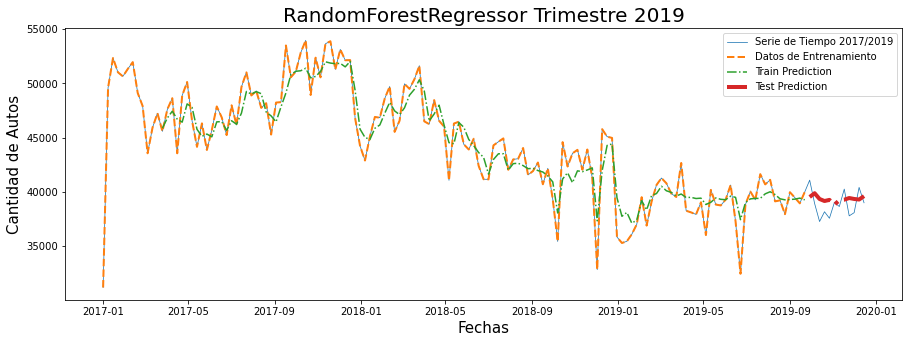

RandomForest Train
RMSE resultado -Train:  1620.631755317414
RandomForest Test
RMSE resultado Test:  1250.8866482869446


In [106]:
plt.figure(figsize=(15,5))


plt.plot(senial.index[:length_total], senial[:length_total], lw = 0.75, label = "Serie de Tiempo 2017/2019")
plt.plot(senial.index[:n_train + look_back], senial[:n_train + look_back], '--', lw= 2, label = 'Datos de Entrenamiento')
plt.plot(senial.index[look_back: look_back + n_train], y_train_pred_randomf, '-.', label = 'Train Prediction')
plt.plot(senial.index[n_train+look_back: length_total], y_test_pred_randomf, '-.', lw = 4, label = 'Test Prediction')

plt.title("RandomForestRegressor Trimestre 2019", color= 'k', fontsize=20)
plt.xlabel('Fechas', fontsize=15)
plt.ylabel('Cantidad de Autos', fontsize=15)


plt.legend()
plt.show()

rmse_train_randomf = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_randomf))

rmse_test_randomf = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_randomf))

print("RandomForest Train")
print("RMSE resultado -Train: ", rmse_train_randomf)


print("RandomForest Test")
print("RMSE resultado Test: ", rmse_test_randomf)


Se puede observar que luego de aplicar GridSearchCV el rendimiento en Test mejora en una proporción baja, posterior a probar múltiples combinaciones distintas para la mejora de hiperparámetros.

Para completar el modelado de la serie de tiempo con RandomForestRegressor, se estudiará la *feature importance* del modelo, es decir, las instancias que tuvieron más relevancia a la hora de predecir el valor próximo.

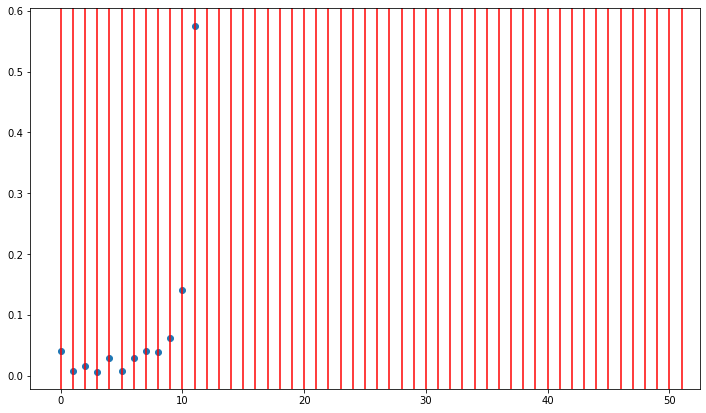

In [107]:
plt.figure(figsize = (12,7))

plt.scatter(np.arange(random_model.feature_importances_.size),random_model.feature_importances_)

for x in range(52):
    plt.axvline(x, linestyle ='-', color= 'r')
    
plt.show()

SE observa que el modelo, de las 12 instancias consignadas para el entrenemiento y luego predecir el valor siguiente, guarda la mayor importanca para las últimas 2 instancias, siendo la última la más reñevante.

El modelo de **RandomForestRegressor** presenta un buen desempeño a grandes rasgos y podría ser una buena eleccion para predecir el año 2020. 

Se implementará un **SARIMAX**, para evaluar si este presenta mejoras ante el modelo elegido. Posteriormente, se utilizará el mejor de los dos para predecir el año 2020. 

**Nota:** Una mejora que se podría implementar para el Proyecto 04, sería utilizar el Modelo de Análisis de Series de Tiempo de Facebook, Prophet, para evaluar si este, ante su simpleza de entrenamiento y evaluación, presenta mejoras ante cualquiera de los dos modelos utilizados en el presente proyecto.

## Modelo SARIMAX

Un poco de información sobre SARIMAX:
     
**p** = Hace referencia a la parte **auto-regresiva** del modelo. Es la que permite incoporar la presencia de valores pasados al modelo. *Ejemplo: Sería igual a decir que es probable que mañana llueva, dado que hace 3 días que está lloviendo.*
     
**d** = Hace referencia a la parte **integrada** del modelo. Esto significa que estaríamos incluyendo términos en el modelo para incorporar el porcentaje de diferenciación aplicado a la Serie de Tiempo. *Ejemplo: Sería igual a decir que, es probable que la temperatura de mañana sea igual a la de hoy si la variación de la misma en los últimos 3 días fue muy poca.*
     
**q** = Hace referencia a la parte que representa la **media móvil** del modelo. Esta permite presentar los errores del modelo como una respresentación lineal de los errores observados de observaciones pasadas.
   

Trabajando con Series de Tiempo que cuentan con efectos estacionales, se utiliza el modelo *SEASON ARIMA* el cual se representa como *ARIMA (pdq)(PDQ)*

El primer grupo de *(pdq)* representan los parámetros no-estacionales de la serie. El segundo conjunto de *(PDQ)* representa los parámetros estacionales de la serie.

In [108]:
# Defino los valores autoregresivos(p) y los valores de media-móvil(q) de la serie.
# Defino los valores de diferenciación(d) de la serie.

p = q = range(0, 13)
d= range(0,3)

# Aquí se generan las distintas combinaciones para los parámetros no-estacionales.
pdq = list(itertools.product(p, d, q))

# Se generan todas las diferentes combinaciones estacionarias
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [109]:
print("Distintas combinaciones de paramateros para -seasonal A.R.I.M.A")
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Distintas combinaciones de paramateros para -seasonal A.R.I.M.A
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 0, 3, 12)
SARIMAX: (0, 0, 2) x (0, 0, 4, 12)


Ya exploradas todas las distintas posibilidades de parámetros, el set óptimo de combinaciones será el que devuelva el mejor resultado. 

Habiendo consignado los distintos parámetros estacionles y no-estacionales del modelo **SARIMAX**, los resultados se evaluarán con el método de medición AIC. El mismo, al momento de evaluar y comparar los resultados obtenidos, devuelve qué tan bien se ajustan los datos a la problemática y al mismo tiempo evalúa el resultado. Un resultado AIC indicará si el modelo se ajusta bien a los datos y cuántas features utiliza para su predicción. 

Un modelo que se ajusta bien sobre los datos y utiliza muchas features para su predicción devolverá un índice AIC alto. Mientras que un modelo que se ajusta bien sobre los datos, pero utiliza menos features, tendrá un índice AIC bajo.

El índice AIC bajo es lo que estamos buscando en este caso para abordar esta problemática.

In [ ]:
y= semanal.cantidad_pasos

ans = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model= sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results= model.fit()
            ans.append([param, param_seasonal, results.aic])

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
        except:
            continue
            
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])


ans_df = ans_df.sort_values(by=['aic'],ascending=True)[0:5]            

SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:3805.9252926512977
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:3411.4686653255944
SARIMAX(0, 0, 0)x(0, 0, 2, 12) - AIC:3097.985679405039
SARIMAX(0, 0, 0)x(0, 0, 3, 12) - AIC:2797.933901609587
SARIMAX(0, 0, 0)x(0, 0, 4, 12) - AIC:7593.261888334179
SARIMAX(0, 0, 0)x(0, 0, 5, 12) - AIC:2043.892815547913
SARIMAX(0, 0, 0)x(0, 0, 6, 12) - AIC:1762.1498296364105
SARIMAX(0, 0, 0)x(0, 0, 7, 12) - AIC:1486.944473766403
SARIMAX(0, 0, 0)x(0, 0, 8, 12) - AIC:1188.9782093439217
SARIMAX(0, 0, 0)x(0, 0, 9, 12) - AIC:955.7721750527612
SARIMAX(0, 0, 0)x(0, 0, 10, 12) - AIC:729.2986115428523
SARIMAX(0, 0, 0)x(0, 0, 11, 12) - AIC:499.8021268361414
SARIMAX(0, 0, 0)x(0, 0, 12, 12) - AIC:273.4188479677117
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:2831.481425978597
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:2595.6728936670715
SARIMAX(0, 0, 0)x(0, 1, 2, 12) - AIC:2347.214297434917
SARIMAX(0, 0, 0)x(0, 1, 3, 12) - AIC:2124.999284928405
SARIMAX(0, 0, 0)x(0, 1, 4, 12) - AIC:nan
SARIMAX(0, 0, 0)

SARIMAX(0, 0, 0)x(3, 2, 8, 12) - AIC:749.3336344559797
SARIMAX(0, 0, 0)x(3, 2, 9, 12) - AIC:514.5925176809344
SARIMAX(0, 0, 0)x(3, 2, 10, 12) - AIC:281.37330430177195
SARIMAX(0, 0, 0)x(3, 2, 11, 12) - AIC:49.45992293534552
SARIMAX(0, 0, 0)x(3, 2, 12, 12) - AIC:32.0
SARIMAX(0, 0, 0)x(4, 0, 0, 12) - AIC:2112.10389201795
SARIMAX(0, 0, 0)x(4, 0, 1, 12) - AIC:2107.1951947580724
SARIMAX(0, 0, 0)x(4, 0, 2, 12) - AIC:2113.3859515135323
SARIMAX(0, 0, 0)x(4, 0, 3, 12) - AIC:2120.407947459689
SARIMAX(0, 0, 0)x(4, 0, 4, 12) - AIC:2073.6971859355517
SARIMAX(0, 0, 0)x(4, 0, 5, 12) - AIC:1896.0333816126006
SARIMAX(0, 0, 0)x(4, 0, 6, 12) - AIC:1659.1438758531115
SARIMAX(0, 0, 0)x(4, 0, 7, 12) - AIC:1427.6657151751813
SARIMAX(0, 0, 0)x(4, 0, 8, 12) - AIC:1201.901991442387
SARIMAX(0, 0, 0)x(4, 0, 9, 12) - AIC:964.0765907801738
SARIMAX(0, 0, 0)x(4, 0, 10, 12) - AIC:735.6208046372235
SARIMAX(0, 0, 0)x(4, 0, 11, 12) - AIC:508.1667538818158
SARIMAX(0, 0, 0)x(4, 0, 12, 12) - AIC:280.21938942982393
SARIMAX(0,

Al iterar sobre cada una de las combinaciones que fueron enunciadas para **pdq** y **PDQ** seasonal, evalúo los resultados de valores AIC obtenidos, teniendo en cuenta que aquellos de menor índice AIC son los modelos que mejor se ajustan a la serie, utilizando la menor cantidad de features. Luego, efectúo distintas combinaciones de parámetros, tanto manuales como las que han sido devueltas por el GridSearch. 

In [ ]:
y= semanal.cantidad_pasos


model= sm.tsa.statespace.SARIMAX(y,
                                order=(10, 1, 8),
                                seasonal_order=(3, 1, 10, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results= model.fit()

print(results.summary().tables[1])

A través de otra función interna de SARIMAX, *plot_diagnostics*, podemos observar los resultados arrojados por el modelo.

En primera instancia, se encuentra el histograma que demuestra la distribución *Gaussiana* de los errores. Es un gráfico poco visible, dado que el RMSE alcanzado es muy bajo por el gran rendimiento del modelo.

Luego, obtenemos el gráfico de *Normal Q-Q*, el cual demuestra la distribución de los residuales, que es estándar.

El gráfico de los residuales, como se había observado y demostrado antes, demuestra un comportamiento completamente aleatorio y un promedio fijo en 0, lo cual es lo ideal para series de tiempo.

Luego de evaluar y eligir el mejor modelo, se grafica con los datos observados reales para comprobar si el modelo se adaptó a la serie. 

Con el comando interno de SARIMAX, *get_prediction*, se indican las fechas sobre las cuales queremos que prediga. 

En este caso, dado que se pide el último trimestre del año 2019, se elige desde *1 de Octubre de 2019* hasta el *31 de Diciembre de 2019*.

Luego, habiendo instanciado la predicción en una variable, se utiliza un comando interno del objeto creado *(prediction)*, con el nombre *conf_int*, el cual devuelve los intervalos de confianza de los valores predichos.

In [ ]:
prediction = results.get_prediction(start= dt.datetime(2019,10,6), dynamic=False)
pred_conf = prediction.conf_int()

Por último, el parámetro *FALSE* se utiliza para modelar en formato **OneStepPrediciton** de SARIMAX. Se utilizarán todos los valores disponibles en la serie de tiempo para generar las predicciones.

In [ ]:
plt.figure(figsize=(20,10))

ax = y['2017':].plot(label='Serie Observada')
prediction.predicted_mean.plot(ax=ax, label='SARIMAX One-Step-Prediction', alpha=0.7)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.2)

plt.title("Desempeño SARIMAX One-Step Trimestre-2019", color= 'k', fontsize=25)
ax.set_xlabel("\n Fecha", fontsize=18, color='indigo')
ax.set_ylabel("\n  Cantidad Autos", loc= 'top', rotation=0, fontsize=18,color='indigo')
plt.xlim(dt.datetime(2019,1,1), dt.datetime(2019,12,29))
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)

plt.legend(fontsize=15)
plt.show()

In [ ]:
y_predicho= prediction.predicted_mean
y_real = y['2019-10-06':]


rmse_sarimax = np.sqrt(metrics.mean_squared_error(y_predicho, y_real))
print("RMSE SARIMAX: ", rmse_sarimax)

Luego de estudiar el modelo *RandomForestRegressor*, realizar *GridSearchCV* para mejorar su rendimiento, volver a evaluar y por otro lado, realizar estos mismos pasos con *SARIMAX*, se observa un clara diferencia en el rendimiento de ambos modelos. 

Se puede concluir que SARIMAX es el mejor modelo para este tipo de problemática. RandomForest, se adaptó muy bien y su implementación fue relativamente sencila. Sin embargo, **SARIMAX** demostró mejores resultados con una implementación un poco más compleja.  El modelo se adapta de manera casi perfecta a la serie de tiempo con un valor RMSE muy bajo. Se estima que su predicción será certera en un principio para 2020 y luego la misma se irá volviendo menos fiable con el pasar de los años.

Habiendo contrastado los resultados, SARIMAX será el modelo elegido para predecir el flujo del año 2020.

In [ ]:
print(f"RandomForestRegressor   RMSE:", rmse_test_randomf)
print(f"SARIMAX One-Step        RMSE:", rmse_sarimax)

##  Prediccion SARIMAX *Año 2020*

In [ ]:
plt.figure(figsize=(20,10))

pred_2020 = results.get_forecast(steps= dt.datetime(2020,12,31))
pred_2020_conf = pred_2020.conf_int()

ax = y.plot(label='Serie Observada')
pred_2020.predicted_mean.plot(ax=ax, label='Prediccion 2020')

ax.fill_between(pred_2020_conf.index,
                pred_2020_conf.iloc[:, 0],
                pred_2020_conf.iloc[:, 1], color='k')

plt.title("Prediccion SARIMAX Año-2020", color= 'k', fontsize=25)
ax.set_xlabel('Fecha', fontsize=18, color='indigo')
ax.set_ylabel('Cantidad Autos', loc= 'top', rotation=0, fontsize=18,color='indigo')
plt.xlim(dt.datetime(2019,10,6), dt.datetime(2020,12,31))
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15)


plt.legend(fontsize= 15)
plt.show()

Se puede observar que la predicción en un principio es estable, pero a medida que pasa el tiempo los intervalos de confianza se vuelven más amplios, dado que la probabilidad de predecir el futuro a extensiones de tiempo tan largas se vuelve cada vez más incierta con cada día que transcurre.

En general, el modelo predice bien sobre el año 2020. Esta misma predicción también será contrastada con el modelo de *Prophet* para predecir a futuro el año 2020 para comprobar cuál arroja mejores resultados.

## Cierre del Proyecto

**Resultado obtenido:**

La investigación y la exploración de datos fue extensa y profunda. 

Se logró comprobar la razón de los registros negativos que presentó la autopista, se generaron preguntas que pudieron ser resueltas. Se aplicaron distintas técnicas de exploración de datos para la interpolación, la descomposición y evaluación de mejores técnicas para abordar esta problemática.

El modelo de *RandomForest* expuesto en clase, resultó de mucha utilidad para empezar con el modelado de la serie y su resultado se encuentra dentro de lo aceptable. Sin embargo, fue el modelo SARIMAX el que mejor se ajustó a la serie.

**Próximos pasos:**

Como conclusión de este Proyecto, se propone como próximo paso, utilizar el modelo *Prophet* de Facebook diseñado especificamente para las series de Tiempo y evaluar si este presenta un mejor desempeño ante el modelo creado de *SARIMAX*. 